In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
!pip install tensorflow-addons
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "timothymathew" # username from the json file
os.environ['KAGGLE_KEY'] = "bb0a99d9d8813ba5bed919ec080aa5cc" # key from the json file
!kaggle datasets download -d hgunraj/covidxct
!unzip -q "/content/covidxct.zip"

In [3]:
imagePathsAll = []
def load_labels(label_file):
    paths, labels = [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            path, label, xmin, ymin, xmax, ymax = line.strip('\n').split()
            paths.append(path)
            imagePathsAll.append(path)
            labels.append(int(label))
    return paths, labels

In [4]:
directory = '/content/2A_images/'
def process_images(paths, labels, bound):
  imageData = []
  boundedLabels = []
  imageCount = [0, 0, 0]
  imageDone = [False, False, False]
  for i in range(len(paths)):
    if (imageCount[labels[i]] < bound):
      imageCount[labels[i]] += 1
      imgTensor = tf.image.decode_image(tf.io.read_file(directory + paths[i]))
      resizedImage = tf.image.resize(imgTensor, [224, 224], method='lanczos3')/255
      coloredImage = tf.image.grayscale_to_rgb(resizedImage)
      imageData.append(coloredImage)
      boundedLabels.append(labels[i])
    else:
      imageDone[labels[i]] = True
      if (imageDone[0] and imageDone[1] and imageDone[2]):
        break
  return tf.convert_to_tensor(imageData), boundedLabels

In [ ]:
trainPaths, trainLabels = load_labels('/content/train_COVIDx_CT-2A.txt')
valPaths, valLabels = load_labels('/content/val_COVIDx_CT-2A.txt')
testPaths, testLabels = load_labels('/content/test_COVIDx_CT-2A.txt')

trainData, trainLabels = process_images(trainPaths, trainLabels, 3500)
valData, valLabels = process_images(valPaths, valLabels, 500)
testData, testLabels = process_images(testPaths, testLabels, 1000)

trainLabels = tf.keras.utils.to_categorical(trainLabels)
valLabels = tf.keras.utils.to_categorical(valLabels)

In [ ]:
vggModel = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(224, 224, 3))
layer = vggModel.output
layer = layers.Flatten()(layer)
layer = layers.Dense(4096, activation="relu")(layer)
layer = layers.Dropout(0.3)(layer)
layer = layers.Dense(512, activation="relu")(layer)
layer = layers.Dropout(0.3)(layer)
layer = layers.Dense(64, activation="relu")(layer)
predictions = layers.Dense(3, activation="softmax")(layer)
model = models.Model(vggModel.input, predictions)

In [8]:
model.compile(optimizer='adamax',  
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(trainData, trainLabels, epochs=11, validation_data=(valData, valLabels))

In [24]:
testPredictions = model.predict(testData)
testPredictionLabels = []
for i in range(len(testPredictions)):
  testPredictionLabels.append(np.argmax(testPredictions[i]))

confusion_mtx = tf.math.confusion_matrix(testLabels, testPredictionLabels)

metric = tf.keras.metrics.Accuracy()
metric.update_state(testLabels, testPredictionLabels)
acc = metric.result().numpy()

metric = tfa.metrics.CohenKappa(num_classes=3, sparse_labels=True)
metric.update_state(testLabels, testPredictionLabels)
cohen = metric.result().numpy()

testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=3)
testPredictionLabels = tf.keras.utils.to_categorical(testPredictionLabels, num_classes=3)

metric = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)
metric.update_state(testLabels, testPredictionLabels)
mcc = metric.result().numpy()

metric = tfa.metrics.F1Score(num_classes=3)
metric.update_state(testLabels, testPredictionLabels)
f1 = metric.result().numpy()

metric = tf.keras.metrics.AUC()
metric.update_state(testLabels, testPredictionLabels)
auc = metric.result().numpy()

loss = tf.keras.losses.CategoricalCrossentropy()
lossCCE = loss(testLabels, testPredictions).numpy()


print("Accuracy: " + str(acc))
print("Cohen's Kappa: " + str(cohen))
print("Matthews Correlation Coefficient: " + str(mcc))
print("F-1 Score: " + str(f1))
print("AUROC: " + str(auc))
print("Loss: " + str(lossCCE))
print("Confusion Matrix: ")
print(confusion_mtx)

Accuracy: 0.33333334
Cohen's Kappa: 0.0
Matthews Correlation Coefficient: 0.0
F-1 Score: [0.  0.  0.5]
AUROC: 0.49999997
Loss: 1.1281868
Confusion Matrix: 
tf.Tensor(
[[  0   0 100]
 [  0   0 100]
 [  0   0 100]], shape=(3, 3), dtype=int32)


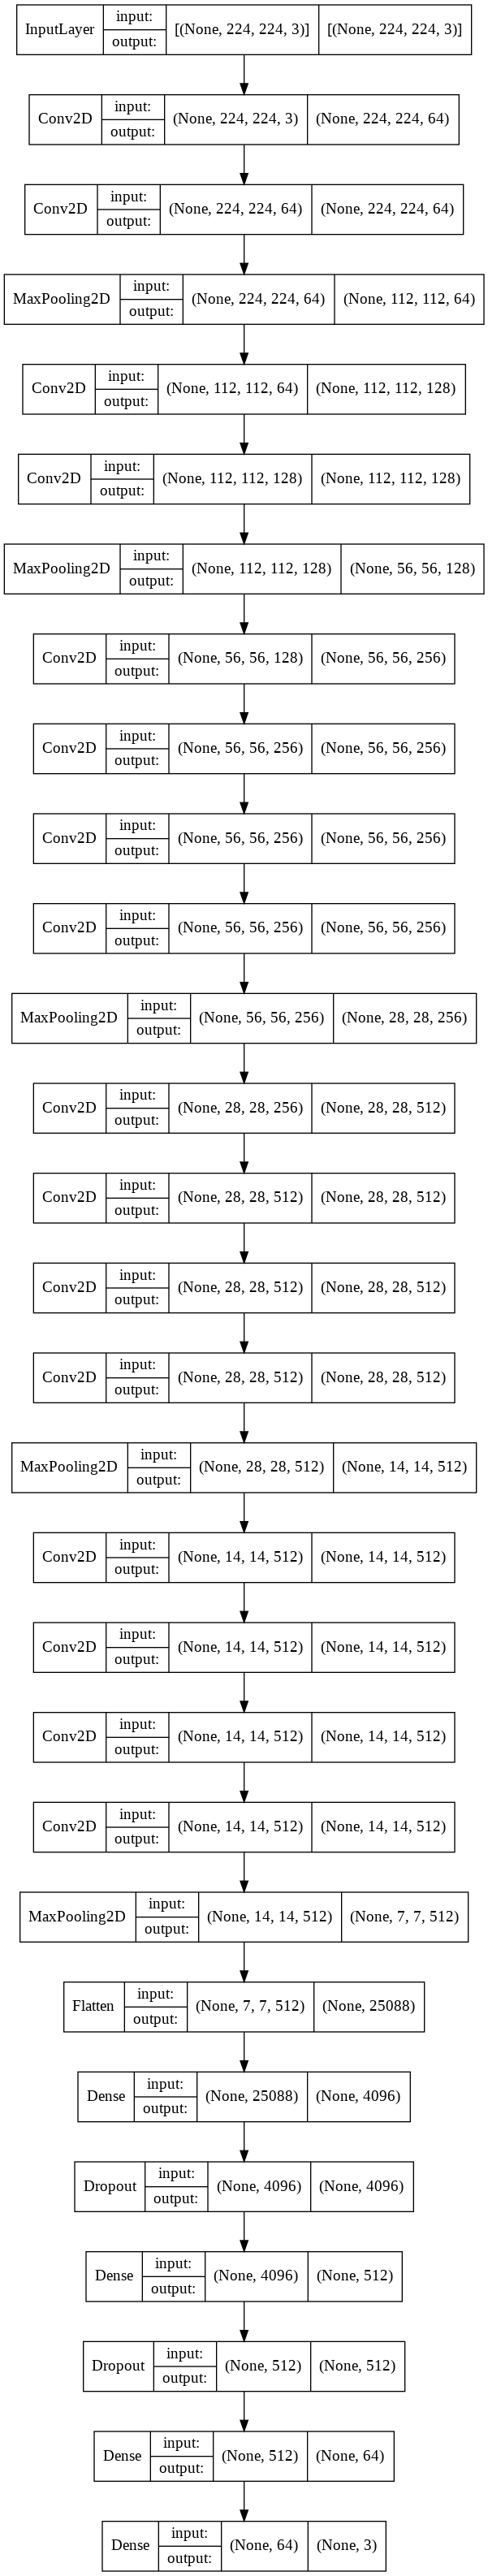

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)